In [ ]:
import torch
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

In [ ]:

#MKae 1000 samples
n_samples=1000
X,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)
type(X)

numpy.ndarray

In [ ]:
len(X),len(y)

(1000, 1000)

In [ ]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],
                      "X2":X[:,1],
                      "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


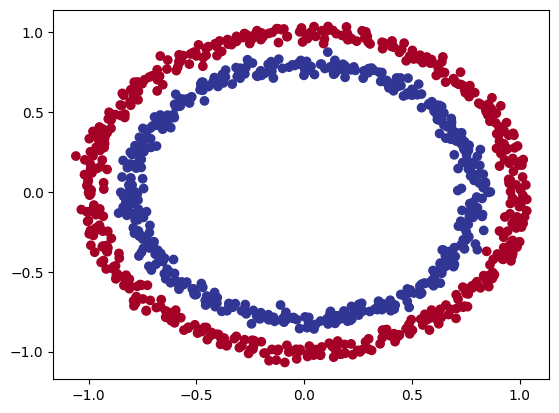

In [ ]:
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [ ]:
type(X)

numpy.ndarray

In [ ]:
#Turn into Tensors:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)


In [ ]:
y[:5]

tensor([1., 1., 1., 1., 0.])

In [ ]:
#Split into train and test

X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,#20% of data for test
                                               random_state=42)


In [ ]:
len(X_train),len(X_test)

(800, 200)

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #Create 2 nn.Linear  layers capable of handling shapes
    self.layer_1=nn.Linear(in_features=2,
                           out_features=5) #takes 2 features and upscale to 5 features
    self.layer_2=nn.Linear(in_features=5,
                           out_features=1)#takes 5 features and out 1
  def forward(self,X):
    return self.layer_2(self.layer_1(X)) #X->layer1->layer2

In [ ]:
model_0=CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Replicate model using nn.sequential
model_0=nn.Sequential(#difference is it already knows forward function
    nn.Linear(in_features=2,out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10,out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0640,  0.5589],
                      [ 0.2731, -0.6989],
                      [ 0.3614, -0.5876],
                      [ 0.4643, -0.1248],
                      [-0.3373,  0.0633],
                      [ 0.1226,  0.4164],
                      [-0.1764, -0.6264],
                      [-0.2593,  0.2456],
                      [ 0.4839, -0.6302],
                      [ 0.1329,  0.1186]])),
             ('0.bias',
              tensor([ 0.4485,  0.3245, -0.2633, -0.3855,  0.2608, -0.3809,  0.2743,  0.5738,
                      -0.2736, -0.1430])),
             ('2.weight',
              tensor([[-0.2082, -0.0023, -0.3031,  0.2076,  0.0412, -0.1649,  0.2685, -0.2561,
                        0.2725,  0.3093]])),
             ('2.bias', tensor([0.0525]))])

In [ ]:
#Make Predictions
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))

torch.round(untrained_preds[:10])


tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])

In [ ]:
#Pick a Loss function and Optimizer
loss_fn=nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [ ]:
#Calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=correct/len(y_pred) *100
  return acc

In [ ]:
# Logits are those values which our model give without any activation function
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3123],
        [-0.3494],
        [ 0.0101],
        [-0.3589],
        [ 0.1572]])

In [ ]:
# Use sigmoid for binary classification
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4226],
        [0.4135],
        [0.5025],
        [0.4112],
        [0.5392]])

In [ ]:
#Find the predicted labels
y_preds=torch.round(y_pred_probs)

y_preds_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_preds_labels

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

In [ ]:
#Train a model
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  #loss and accuracy
  loss=loss_fn(y_logits,y_train) # logits because bcewithlogit loss funtion expects logits as input
  acc=accuracy_fn(y_true=y_train,y_pred=y_preds)

  #optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_preds,
                      y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_preds)
    if epoch % 10==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.70321 | Acc: 47.25% | Test Loss: 0.73069 | Test Acc: 51.50%
Epoch: 10 | Loss: 0.69984 | Acc: 47.62% | Test Loss: 0.73999 | Test Acc: 50.00%
Epoch: 20 | Loss: 0.69731 | Acc: 47.88% | Test Loss: 0.73189 | Test Acc: 51.50%
Epoch: 30 | Loss: 0.69535 | Acc: 47.50% | Test Loss: 0.72689 | Test Acc: 52.50%
Epoch: 40 | Loss: 0.69376 | Acc: 48.25% | Test Loss: 0.71759 | Test Acc: 54.00%
Epoch: 50 | Loss: 0.69247 | Acc: 49.00% | Test Loss: 0.71829 | Test Acc: 53.50%
Epoch: 60 | Loss: 0.69138 | Acc: 51.75% | Test Loss: 0.69798 | Test Acc: 56.00%
Epoch: 70 | Loss: 0.69047 | Acc: 51.00% | Test Loss: 0.69868 | Test Acc: 55.50%
Epoch: 80 | Loss: 0.68968 | Acc: 51.00% | Test Loss: 0.69697 | Test Acc: 55.00%
Epoch: 90 | Loss: 0.68900 | Acc: 51.00% | Test Loss: 0.69628 | Test Acc: 55.50%
Epoch: 100 | Loss: 0.68839 | Acc: 51.25% | Test Loss: 0.69508 | Test Acc: 55.50%
Epoch: 110 | Loss: 0.68783 | Acc: 51.38% | Test Loss: 0.69438 | Test Acc: 56.00%
Epoch: 120 | Loss: 0.68733 | Acc: 52.25

In [ ]:
from urllib import request
# Visualization because from metrics it looks like our model does not learning anything
import requests
from pathlib import Path

#DOwnload helper function from Learn pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

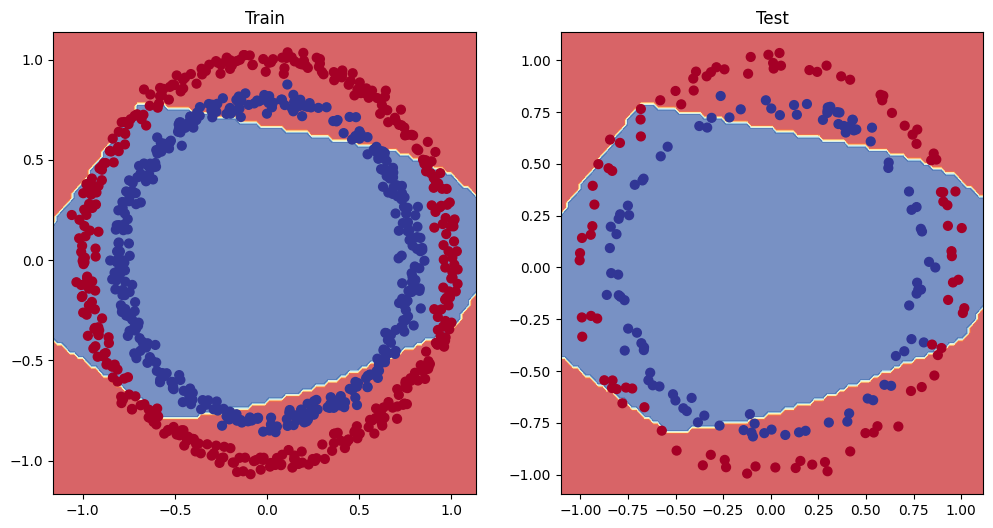

In [ ]:
#Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## Impproving a model
* Add more layers - give more chances to learn
* Add more hidden units - instead of 5 giv 10 hidden units
* Fit for Longer
* Change the learning rate
* Change the optimizer

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    #Create 2 nn.Linear  layers capable of handling shapes
    self.layer_1=nn.Linear(in_features=2,
                           out_features=10) #takes 2 features and upscale to
    self.layer_2=nn.Linear(in_features=10,
                           out_features=10)
    self.layer_3=nn.Linear(in_features=10,
                           out_features=1)
  def forward(self,X):
    return self.layer_3(self.layer_2(self.layer_1(X))) #X->layer1->layer2->layer3

In [ ]:
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Train a model
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_1.train()
  y_logits=model_1(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  #loss and accuracy
  loss=loss_fn(y_logits,y_train) # logits because bcewithlogit loss funtion expects logits as input
  acc=accuracy_fn(y_true=y_train,y_pred=y_preds)

  #optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    test_logits=model_1(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_preds,
                      y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_preds)
  if epoch % 100==0:
    print(f" Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

 Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 100 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 200 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 300 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 400 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 500 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 600 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 700 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 800 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00
 Epoch: 900 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.75541 | Test Acc: 51.00


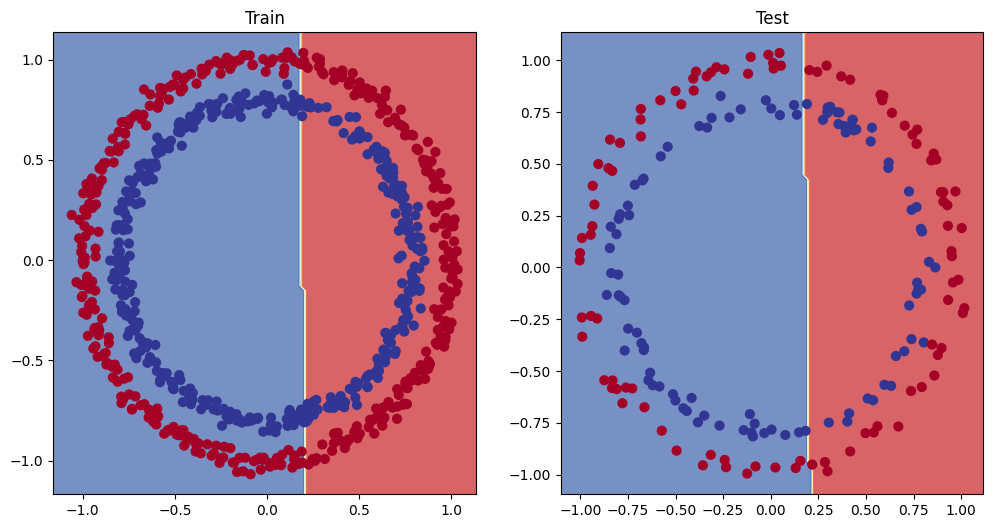

In [ ]:
#Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [ ]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [ ]:
model_2=nn.Sequential(
    nn.Linear(in_features=1,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

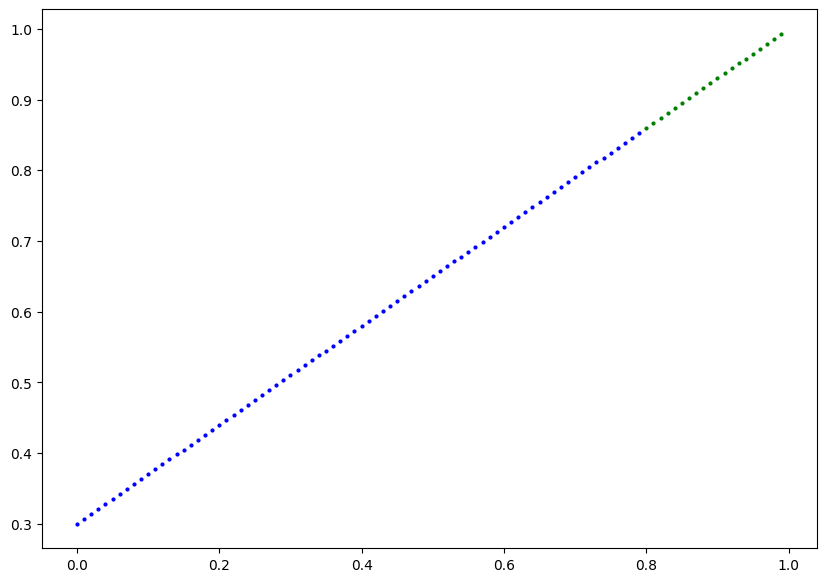

In [ ]:
plot_predictions(predictions= y_preds,
                 train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

In [ ]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                          lr=0.01)

In [ ]:
#Train a model
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_2.train()
  y_pred=model_2(X_train)
  loss=loss_fn(y_pred,y_train)
  #optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    test_pred=model_2(X_test)
    test_loss=loss_fn(test_pred,
                      y_test)
  if epoch % 100==0:
    print(f" Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

 Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
 Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
 Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
 Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
 Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
 Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
 Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
 Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
 Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
 Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


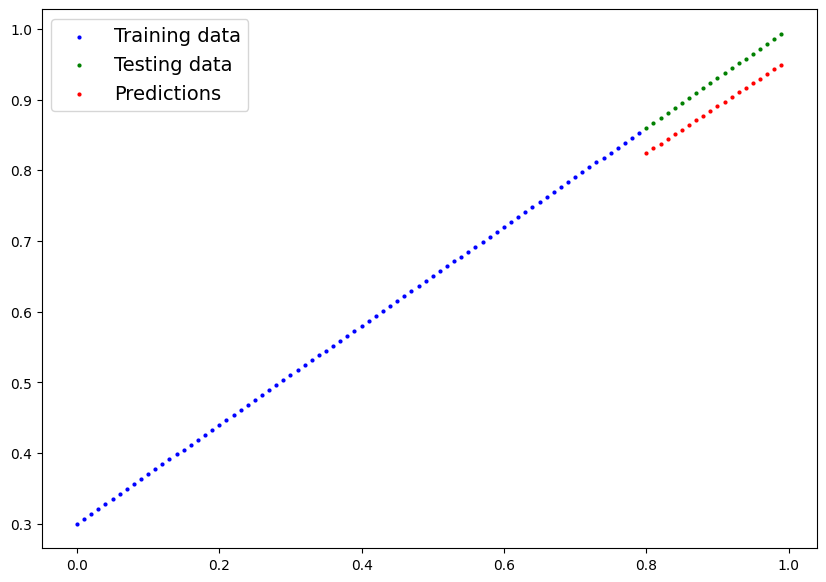

In [ ]:
model_2.eval()
with torch.inference_mode():
  y_preds=model_2(X_test)

plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=y_preds)

### Missing Piece: non-linearity

In [ ]:
#Building a model with non-linearity
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,
                           out_features=10)
    self.layer_2=nn.Linear(in_features=10,
                           out_features=10)
    self.layer_3=nn.Linear(in_features=10,
                           out_features=1)
    self.relu=nn.ReLU() # non-linear activation function
  def forward(self,X):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X))))) #X->layer1->layer2->layer3

In [ ]:
model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
#Pick a Loss function and Optimizer
loss_fn=nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function
optimizer=torch.optim.SGD(params=model_3.parameters(),
                          lr=0.1)

In [ ]:
# Training

#Train a model
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_3.train()
  y_logits=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #loss and accuracy
  loss=loss_fn(y_logits,y_train) # logits because bcewithlogit loss funtion expects logits as input
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_pred,
                      y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)
  if epoch % 100==0:
    print(f" Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x1 and 2x10)

IndexError: index 1 is out of bounds for dimension 1 with size 1

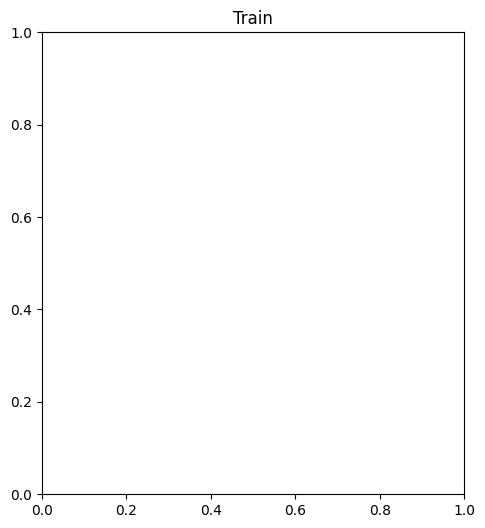

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10],y_test[:10]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x1 and 2x10)

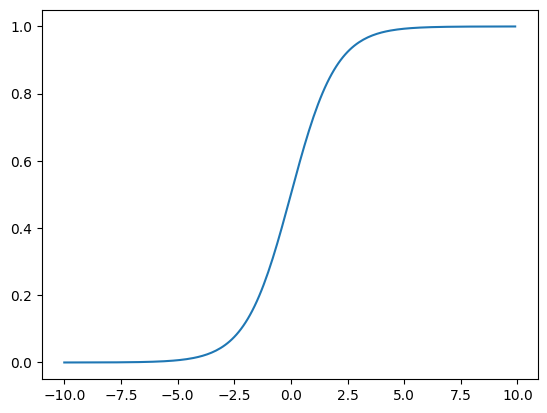

In [ ]:
A=torch.arange(-10,10,0.1)
B=torch.sigmoid(A)
plt.plot(A,B)

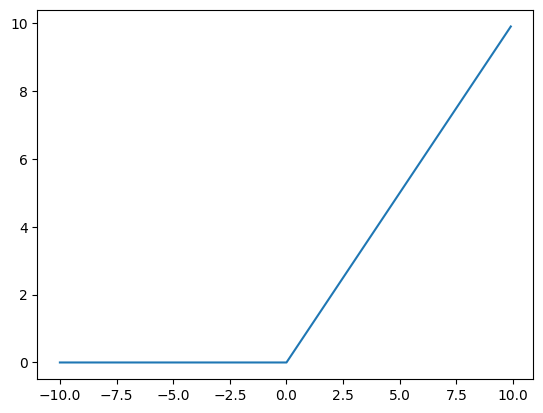

In [ ]:
B=torch.relu(A)
plt.plot(A,B)

In [ ]:
num_classes=4
num_features=2
random_seed=42
#Create Multi class blobs

X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=num_features,
                         centers=num_classes,
                         cluster_std=1.5, #give cluster some randomness or shake them up
                         random_state=random_seed)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.float)



In [ ]:
 #Split into train-split
X_train,X_test,y_train,y_test=train_test_split(X_blob,
                                               y_blob,
                                               test_size=0.2,
                                               random_state=random_seed)

In [ ]:
y_train=y_train.type(torch.long)
y_test=y_test.type(torch.long)

In [ ]:
len(X_blob_train),len(X_blob_test)

(800, 200)

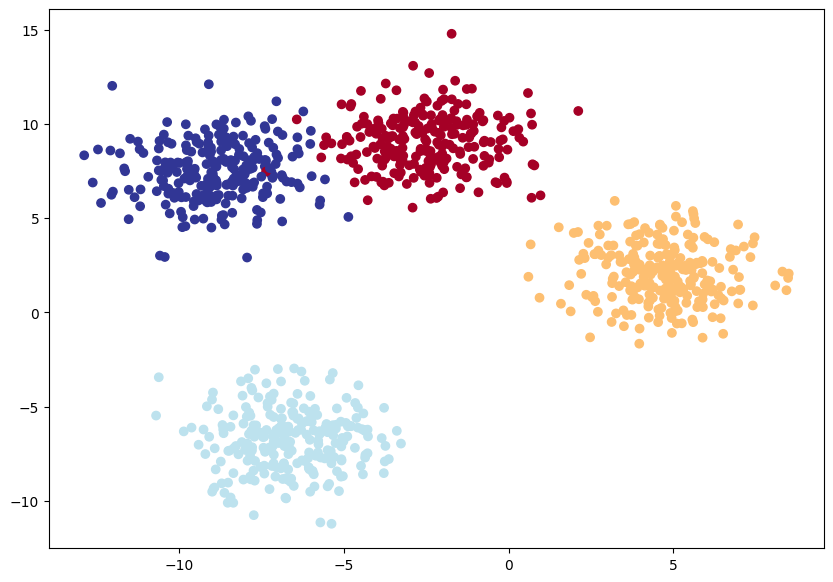

In [ ]:
#Plotting Data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [ ]:
#Build
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,X):
    return self.linear_layer_stack(X)


In [ ]:
model_4=BlobModel(2,4,10)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [ ]:
X_blob_train.type()

'torch.FloatTensor'

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test)
  y_pred_probs=torch.softmax(y_logits,dim=1) #softmax to convert to probabilities
  print(y_logits[:5])
  print(y_pred_probs[:5])
  y_preds=torch.argmax(y_pred_probs,dim=1)
  print(y_preds[:5])

tensor([[-0.3184,  0.1236,  0.0300, -0.1944],
        [-0.0324, -0.2282, -0.3603, -0.2892],
        [-0.0531, -0.1521, -0.3156, -0.2874],
        [-0.1858, -0.0169, -0.1213, -0.2219],
        [-0.2040, -0.1441, -0.2306, -0.3141]])
tensor([[0.1959, 0.3048, 0.2775, 0.2218],
        [0.3016, 0.2479, 0.2172, 0.2333],
        [0.2885, 0.2613, 0.2219, 0.2282],
        [0.2372, 0.2809, 0.2530, 0.2288],
        [0.2544, 0.2701, 0.2477, 0.2278]])
tensor([1, 0, 0, 1, 1])


In [ ]:
X_blob_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]])

In [ ]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_4.train()
  y_logits=model_4(X_blob_train)
  y_preds=torch.softmax(y_logits,dim=1)
  y_preds=torch.argmax(y_preds,dim=1)
  loss=loss_fn(y_logits,y_blob_train)
  # acc=accuracy_fn(y_true=y_blob_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_preds=torch.softmax(test_logits,dim=1)
    test_preds=torch.argmax(test_preds,dim=1)
    test_loss=loss_fn(test_logits,y_blob_test)
  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Loss: 1.50867 | Test Loss: 1.41169
tensor([2, 1, 1, 1, 1]) tensor([1, 3, 2, 1, 0])
Epoch: 100 | Loss: 0.03805 | Test Loss: 0.02926
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 200 | Loss: 0.02934 | Test Loss: 0.01926
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 300 | Loss: 0.02742 | Test Loss: 0.01680
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 400 | Loss: 0.02650 | Test Loss: 0.01560
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 500 | Loss: 0.02588 | Test Loss: 0.01483
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 600 | Loss: 0.02540 | Test Loss: 0.01427
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 700 | Loss: 0.02498 | Test Loss: 0.01382
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 800 | Loss: 0.02461 | Test Loss: 0.01343
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])
Epoch: 900 | Loss: 0.02427 | Test Loss: 0.01308
tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])


In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_test)
  y_pred_probs=torch.softmax(y_logits,dim=1)
  y_preds=torch.argmax(y_pred_probs,dim=1)

  print(y_preds[:10])
  print(y_test[:10])
#

NameError: name 'X_test' is not defined

In [ ]:
#building an model
model=nn.Sequential(
  nn.Linear(in_features=2,out_features=10),
  nn.ReLU(),
  nn.Linear(in_features=10,out_features=10),
  nn.ReLU(),
  nn.Linear(in_features=10,out_features=4),

)

In [ ]:
#creating a testing and traing loop
def train_and_test(model,loss_fn,optimizer,epochs=100):

  for epoch in range(epochs):
  #TRAIN
    #setting model to train
    model.train()
    #doing the forward pass
    logits_ontrain=model(X_train)
    #converting the raw output into probabilties
    pred_train=torch.softmax(logits_ontrain,dim=1)
    #converting them to labels
    pred_train=torch.argmax(pred_train,dim=1)
    #calculting the loss on logit as cross entropy work on logits
    loss_train=loss_fn(logits_ontrain,y_train)
    #setting zero grad
    optimizer.zero_grad()
    #doing backward pass
    loss_train.backward()
    #updating the parameters
    optimizer.step()
  #TEST
    #setting to test mode
    model.eval()
    with torch.inference_mode():
      logits_ontest=model(X_test)
      pred_test=torch.softmax(logits_ontest,dim=1)
      pred_test=torch.argmax(pred_test,dim=1)
      loss_test=loss_fn(logits_ontest,y_test)

    # Print out what's happenin
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train}| Test loss: {loss_test}")

In [ ]:
train_and_test(model,loss_fn,optimizer,1000)

Epoch: 0 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 100 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 200 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 300 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 400 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 500 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 600 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 700 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 800 | Loss: 1.5086679458618164| Test loss: 1.507413625717163
Epoch: 900 | Loss: 1.5086679458618164| Test loss: 1.507413625717163


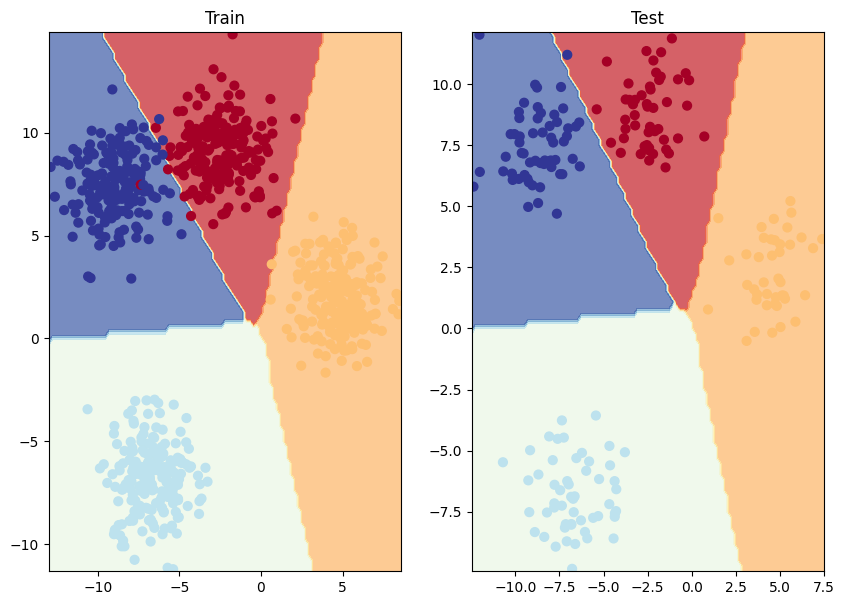

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_test,y_test)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 24.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy
metric=Accuracy(task="multiclass",num_classes=4)
metric(test_preds,y_test)

tensor(0.9950)

### Excercise

In [ ]:
X_moon,y_moon=make_moons(n_samples=1000,
                      noise=0.05,
                      random_state=42)

In [ ]:
df=pd.DataFrame({"X1": X_moon[:,0],
                 "X2": X_moon[:,1],
                 "label": y_moon})
df.head()

,X1,X2,label
0,-0.021371,0.406186,1
1,0.976700,-0.458323,1
2,0.904059,-0.376520,1
3,0.377363,-0.397037,1
4,-0.841926,0.530587,0


In [ ]:
X_moon=torch.from_numpy(X_moon).type(torch.float)
y_moon=torch.from_numpy(y_moon).type(torch.float)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_moon,
                                               y_moon,
                                               test_size=0.2,
                                               random_state=42)

In [ ]:
model=nn.Sequential(
    nn.Linear(in_features=2,out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10,out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10,out_features=1)

)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [ ]:
epochs=1000
for epoch in range(epochs):
  model.train()
  y_logits=model(X_train).squeeze()
  y_preds=torch.sigmoid(y_logits)
  y_preds=torch.round(y_preds)
  loss=loss_fn(y_logits,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits=model(X_test).squeeze()
    test_preds=torch.sigmoid(test_logits)
    test_preds=torch.round(test_preds)
    test_loss=loss_fn(test_preds,y_test)
  if epoch % 100==0:
    print(loss,test_loss)

tensor(0.6820, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.6571)
tensor(0.3193, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5851)
tensor(0.2392, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5568)
tensor(0.2279, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5568)
tensor(0.2177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5537)
tensor(0.2001, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5487)
tensor(0.1704, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5375)
tensor(0.1290, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5251)
tensor(0.0884, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5144)
tensor(0.0537, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.5051)


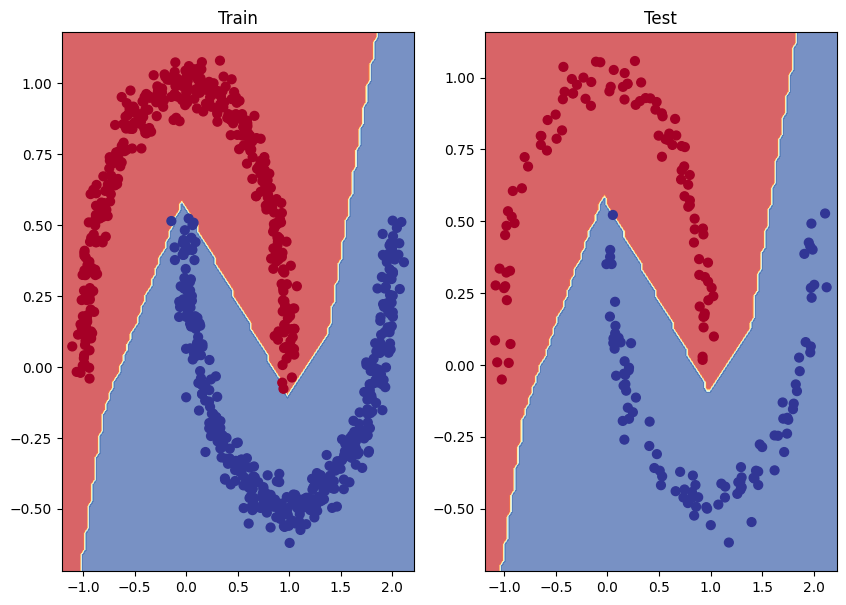

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_test,y_test)

In [ ]:
A=torch.arange(-10,10)
A

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

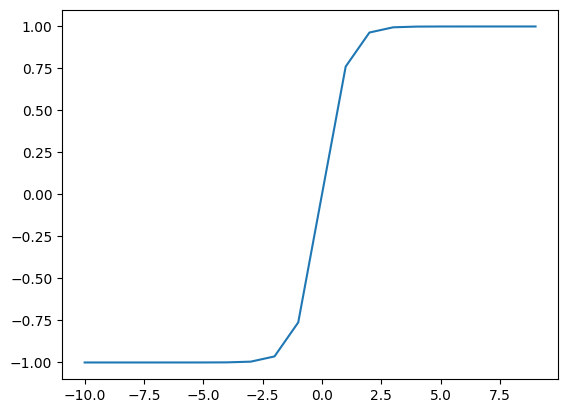

In [ ]:
B=torch.tanh(A)
plt.plot(A,B)